clean version available at:  
- https://github.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/tree/main/Seminar4

Installing packages:
```
# polara
pip install --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara
```

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds, LinearOperator
import seaborn as sns
sns.set_theme(style='white', context='paper')
%config InlineBackend.figure_format = "svg"

from polara import get_movielens_data

from dataprep import transform_indices, leave_last_out, verify_time_split, reindex_data, generate_interactions_matrix
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items

# Preparing data

In [2]:
data = get_movielens_data(include_time=True)

In [3]:
training_, holdout_ = leave_last_out(data, 'userid', 'timestamp')
verify_time_split(training_, holdout_)

In [4]:
training, data_index = transform_indices(training_, 'userid', 'movieid')
holdout = (
    reindex_data(holdout_, data_index, filter_invalid=True)
    .sort_values('userid')
)

In [6]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    test_users = holdout[data_index['users'].name].values
)

In [7]:
userid = data_description['users']
seen_idx_mask = training[userid].isin(data_description['test_users'])
testset = training[seen_idx_mask]

## PureSVD

In [10]:
def build_svd_model(config, data, data_description):
    source_matrix = generate_interactions_matrix(data, data_description, rebase_users=False)
    _, s, vt = svds(
        source_matrix.astype('f8'),
        k=config['rank'],
        return_singular_vectors='vh'
    )
    sidx = np.argsort(-s)
    singular_values = s[sidx]
    item_factors = np.ascontiguousarray(vt[sidx, :].T)
    return item_factors, singular_values

In [11]:
svd_config = {'rank': 200}

V, sigma = svd_params = build_svd_model(svd_config, training, data_description)

In [14]:
V.shape, sigma.size

((3704, 200), 200)

In [15]:
# verify orthogonality
np.testing.assert_almost_equal(
    V.T @ V,
    np.eye(svd_config['rank']), decimal=14
)

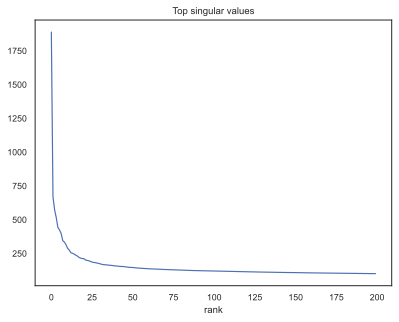

In [16]:
pd.Series(sigma).plot(title='Top singular values', xlabel='rank');

## "Shifted" PureSVD

SVD of
$$A=\hat{A}_0+\alpha \boldsymbol{e}_M \boldsymbol{e}_N^{\top}$$

In [17]:
data_description['average_rating'] = data[data_description['feedback']].mean()

In [18]:
def build_shifted_model(config, data, data_description):
    source_matrix = generate_interactions_matrix(data, data_description, rebase_users=False)
    average_rating = data_description['average_rating']
    centered_matrix = source_matrix._with_data(source_matrix.data - average_rating)

    # define matvecs for the LinearOperator of the shifted matrix
    def shifted_mv(v):
        return centered_matrix.dot(v) + average_rating*v.sum()

    def shifted_rmv(v):
        return centered_matrix.T.dot(v) + average_rating*v.sum()

    shifted_matrix = LinearOperator(
        source_matrix.shape,
        shifted_mv,
        shifted_rmv
    )
    _, s, vt = svds(shifted_matrix, k=config['rank'])
    sidx = np.argsort(-s)
    singular_values = s[sidx]
    item_factors = np.ascontiguousarray(vt[sidx, :].T)
    return item_factors, singular_values

In [19]:
V_shift, sigma_shift = shifted_params = build_shifted_model(
    svd_config,
    training,
    data_description
)

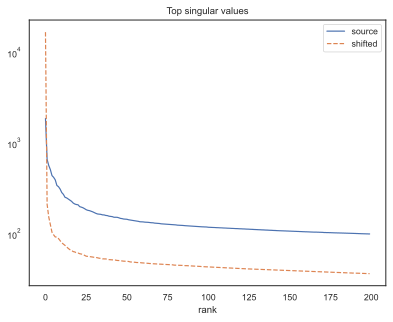

In [20]:
ax = pd.Series(sigma).plot(
    title='Top singular values',
    xlabel='rank',
    label='source',
    legend=True,
    logy=True
)
pd.Series(sigma_shift).plot(
    legend=True,
    label='shifted',
    ax=ax,
    ls='--'
);

Let's sompare top singular value against the estimation:

In [21]:
# estimated leading singular value
training.rating.mean() * np.sqrt(data_description['n_users'] * data_description['n_items'])

16939.913804028987

In [22]:
# computed leading singular value
sigma_shift.max()

16942.14315675567

Very close!

Let's see how singular values accumulate from the end.

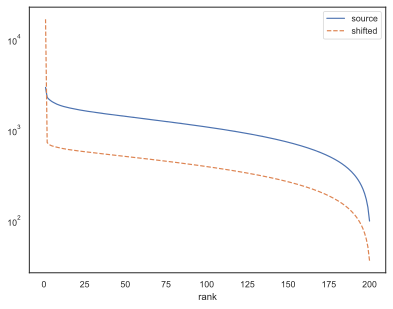

In [23]:
rev_sigma_idx = np.arange(svd_config['rank'], 0, -1)
ax = pd.Series(sigma[::-1]**2, index=rev_sigma_idx).cumsum().pow(0.5).plot(
    title='',
    xlabel='rank',
    label='source',
    legend=True,
    logy=True
)
pd.Series(sigma_shift[::-1]**2, index=rev_sigma_idx).cumsum().pow(0.5).plot(
    legend=True,
    label='shifted',
    ax=ax,
    ls='--'
);

Let's stop here for a moment. What are possible conclusions from this graph:
1. we reduced approximation error
2. seems like we'll need lower rank value, as most of the variation is already explained by the first singular triplet.

Let's scrutinize a bit over these two conclusions.

Obviously, singular values indicate general reduction of error, which includes errors computed on unknown ratings. Let's check error only for known ratings.

In [26]:
def compute_train_rmse(item_factors, data, data_description):
    source_matrix = generate_interactions_matrix(data, data_description, rebase_users=True)
    predicted = puresvd_predict(source_matrix, item_factors)
    true_ratings = source_matrix.data
    return rmse(true_ratings, predicted)

def puresvd_predict(source_matrix, item_factors):
    nnz_user, nnz_item = source_matrix.nonzero()
    # (AV)V^T
    user_factors = source_matrix.dot(item_factors)
    predicted = (user_factors[nnz_user] * item_factors[nnz_item]).sum(axis=1)
    return predicted

def rmse(true_ratings, predicted):
    return np.sqrt(np.power(true_ratings - predicted, 2).mean())


In [27]:
# PureSVD
svd_rmse = compute_train_rmse(V, training, data_description)
print(f'{svd_rmse=:.2f}')

svd_rmse=1.81


In [33]:
def compute_train_rmse_shifted(item_factors, data, data_description):
    source_matrix = generate_interactions_matrix(data, data_description, rebase_users=False)
    predicted = shifted_predict(source_matrix, item_factors)
    true_ratings = source_matrix.data
    return rmse(true_ratings, predicted)

def shifted_predict(source_matrix, item_factors):
    nnz_user, nnz_item = source_matrix.nonzero()
    average_rating = source_matrix.data.mean()
    centered_matrix = source_matrix._with_data(source_matrix.data - average_rating)
    # (A + aee^T)V = AV + a e (e^TV)
    user_factors = centered_matrix.dot(item_factors) + average_rating * item_factors.sum(axis=0)
    predicted = (user_factors[nnz_user] * item_factors[nnz_item]).sum(axis=1)
    return predicted

In [34]:
# Shifted PureSVD
shifted_rmse = compute_train_rmse_shifted(V, training, data_description)
print(f'{shifted_rmse=:.2f}')

shifted_rmse=1.38


Indeed, an improvement is quite substantial.

Let's evaluate with more relevant metrics:

# Evaluation 

In [39]:
def svd_model_scoring(params, data, data_description):
    item_factors, sigma = params
    test_matrix = generate_interactions_matrix(data, data_description, rebase_users=True)
    scores = test_matrix.dot(item_factors) @ item_factors.T
    return scores

## PureSVD

In [40]:
svd_scores = svd_model_scoring(svd_params, testset, data_description)

In [41]:
downvote_seen_items(svd_scores, testset, data_description)

In [42]:
svd_recs = topn_recommendations(svd_scores, topn=10)
model_evaluate(svd_recs, holdout, data_description)

(0.08264325935740312, 0.028954452488735363, 0.37661987041036715)

## Shifted

In [43]:
def shifted_model_scoring(params, testset, data_description):
    item_factors, sigma = params
    average_rating = data_description['average_rating']
    test_matrix = generate_interactions_matrix(testset, data_description, rebase_users=True)
    centered_matrix = test_matrix._with_data(test_matrix.data - average_rating)
    user_factors = centered_matrix.dot(item_factors) + average_rating*item_factors.sum(axis=0)
    scores = user_factors @ item_factors.T
    return scores

In [44]:
shifted_scores = shifted_model_scoring(
    shifted_params,
    testset,
    data_description
)

In [45]:
downvote_seen_items(shifted_scores, testset, data_description)

In [46]:
shifted_recs = topn_recommendations(shifted_scores)
model_evaluate(shifted_recs, holdout, data_description)

(0.05366015236833389, 0.019440764049906148, 0.31668466522678185)

So, we improved RMSE loss almost by 2.5x, but lost in terms of HitRate by more than 1.5x.

Let's check for a range of rank values,  as the models do not have to have the same rank for optimal quality.

# Grid-search experiment

In [ ]:
def svd_metrics(params, testset, data_description, shifted=False):
    '''Calculates evaluation metrics for SVD models.'''
    scoring_func = shifted_model_scoring if shifted else svd_model_scoring
     ... # implement recommendations generation pipeline here
    return model_evaluate(recs, holdout, data_description)

def truncate_svd_params(params, rank):
    '''Truncates model parameters to specified rank value.'''
    item_factors, sigma = params
    assert rank <= len(sigma)
    return item_factors[:, :rank], sigma[:rank]

In [ ]:
svd_ranks = [b*2**i for i in range(7) for b in [2, 3]]

svd_config = ... # type your code here

puresvd_params = build_svd_model(svd_config, training, data_description)
shifted_params = build_shifted_model(svd_config, training, data_description)

puresvd_metrics = {}
shifted_metrics = {}
for rank in svd_ranks:
    puresvd_metrics[rank] = ... # type your code here
    shifted_metrics[rank] = ... # type your code here

In [ ]:
puresvd_res = pd.DataFrame.from_dict(data=puresvd_metrics, columns=['hr', 'mrr', 'cov'], orient='index')
shifted_res = pd.DataFrame.from_dict(data=shifted_metrics, columns=['hr', 'mrr', 'cov'], orient='index')

In [ ]:
ax = pd.Series(puresvd_res['hr']).plot(label='Source', legend=True, title='HR results')
pd.Series(shifted_res['hr']).plot(ax=ax, label='Shifted', legend=True);

In [ ]:
ax = pd.Series(puresvd_res['cov']).plot(label='Source', legend=True, title='Coverage')
pd.Series(shifted_res['cov']).plot(ax=ax, label='Shifted', legend=True);

In [ ]:
metrics_combined = pd.concat(
    [puresvd_res[['hr', 'cov']], shifted_res[['hr', 'cov']]],
    keys = ['source', 'shifted'],
    names = ['model', 'rank'],
    axis = 0
).reset_index()

sns.scatterplot(data=metrics_combined, x='cov', y='hr', hue='model');